In [1]:
import sys
sys.path.append('E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/CSA_SNN')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

import resnet_2

from datetime import datetime
import glob
import random

from eco2ai import Tracker

E:\Code\Spiking-Visual-attention-for-Medical-image-segmentation\Models\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2.resnet34().to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 4, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 4, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 4, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12           [32, 4, 1, 1, 1]               0
           Conv3d-13           [32, 1, 1, 1, 1]               4
             ReLU-14           [32, 1, 

In [3]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 # 1e-3 -> 1e-4 -> 5e-5 
Batch_size  = 32
num_epochs  = 60
num_workers = 4
IMAGE_HEIGHT = 256 # 256 -> 512 originally
IMAGE_WIDTH  = 256 # 256 -> 512 originally
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None
IMG_DIR      =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [4]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    tracker = Tracker(
        project_name="CSA_SNN_Training_Project",
        experiment_description="Training CSA Spiking Model",
        file_name="CSA_SNN_eco2ai_logs.csv",
        alpha_2_code="EG",  
    )
    tracker.start()
    
    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device) 

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        
        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())

    tracker.stop()
 
    nasar = model.calculate_nasar()

    return running_loss/len(loader), nasar 

In [ ]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)  
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]
    train_nasar=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        val_acc_loaded, val_dice_loaded = check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

In [6]:
if __name__ == "__main__": 
    main()

In [ ]:
from google.colab import files

# Download the Eco2AI Logs
files.download("CSA_SNN_eco2ai_logs.csv")

✅ Log loaded successfully.

🔍 Summary:
   🕒 Duration: 3659.15 seconds
   ⚡ Power Consumed: 0.0394 kWh
   🌱 CO₂ Emissions: 0.0187 kg
✅ Summary plot saved as 'CSA_SNN_eco2ai_summary_plot.png'.


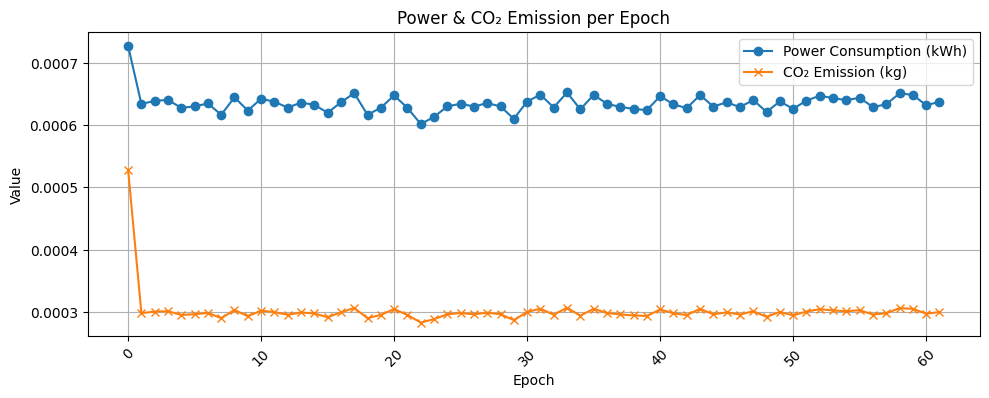

In [6]:
summarize_eco2ai_log("E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/CSA_SNN/eco2ai/CSA_SNN_eco2ai_logs.csv")

In [ ]:
# Download the Eco2AI Plot
files.download("CSA_SNN_eco2ai_summary_plot.png")